# Initialization

In [80]:
!pip install --upgrade pip
!pip install numpy
!pip install matplotlib
!pip install pandas 
!pip install scipy

In [81]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
import pandas as pd

# 1. Let us select $\omega = \sqrt{2}$. Compute a periodic orbit of period 2π near the origin. Compute its stability.


To solve this, we can make use of the scipy.integrate library which cointains different numerical integration methods. The library contains the same Runge-Kutta method proposed with the given C code. Here it follows an example of how it can be used to solve a system of differential equations. 

In [82]:
import numpy as np
from scipy.integrate import solve_ivp

def pendulum(t, X0, omega=np.sqrt(2), epsilon=1e-2):
    x, y = X0
    dx = y
    dy = -omega**2 * np.sin(x) + epsilon * np.sin(t)
    return [dx, dy]

t_span = [0, 2*np.pi]
X0 = [0.1, 0] # initial conditions
omega = np.sqrt(2)
epsilon = 1e-2

sol = solve_ivp(pendulum, t_span, X0, method='RK45', args=(omega, epsilon))

x = sol.y[0]
y = sol.y[1]

print("x:", x)
print("y:", y)
print("Time steps:", sol.t)

x: [ 0.1         0.09999755  0.09970338  0.07724285 -0.00197292 -0.0797396
 -0.08236219 -0.01613257  0.06760395  0.08814902  0.02947348 -0.05992349
 -0.08933286]
y: [ 0.         -0.00098997 -0.01086548 -0.0889517  -0.13665614 -0.0667601
  0.05923272  0.12991188  0.08765102 -0.03128435 -0.12606652 -0.10769135
 -0.0542322 ]
Time steps: [0.00000000e+00 4.95875551e-03 5.45463106e-02 4.89038806e-01
 1.13950811e+00 1.84007157e+00 2.52282501e+00 3.17097656e+00
 3.87359291e+00 4.54300138e+00 5.22869084e+00 5.92803572e+00
 6.28318531e+00]


In the considered case we need to use the numerical intregration method to solve the following Cauchy problem 
$$\begin{cases}
\dot{x} = y \\
\dot{y} = -\omega^2 sin(x)+\epsilon sin(t) \\
\dot{v}_{11} = v_{21} \\
\dot{v}_{12} = v_{22} \\
\dot{v}_{21} = -\omega^2 cos(x)v_{11} \\
\dot{v}_{22} = -\omega^2 cos(x)v_{12}
\end{cases}$$
In particular, since we're interested in $2\pi$ periodic orbits, we'll take the value of $x$ and $v$ which will be returned as the vector xv_final and the values of $v_{11}$, $v_{12}$, $v_{21}$, and $v_{22}$ at time $2\pi$, which will be returned as a matrix $V$
$$xy\_final = \begin{bmatrix} x \\ y \end{bmatrix}, \;\;\; V=\begin{bmatrix} v_{11} & v_{12} \\ v_{21} & v_{22} \end{bmatrix}, \;\;\; \text{at the end of the flow } (t=2\pi)$$ 
This allows us to obtain both the flow and the variationals which are the derivative relative to the initial point. 

In [83]:
# Initial conditions
# x, y, v12, v21 = 0
# v11, v22 = 1
omega = np.sqrt(2)
epsilon = 1e-2
initial_conditions = [0, 0, 1, 0, 0, 1]
t_span = [0, 2*np.pi]

def Cauchy_problem_1(t, initial_conditions, omega, epsilon=1e-2):
    x, y, v11, v12, v21, v22 = initial_conditions
    dx = y
    dy = -(omega**2)*np.sin(x) + epsilon * np.sin(t)
    dv11 = v21
    dv12 = v22
    dv21 = -(omega**2)*np.cos(x)*v11
    dv22 = -(omega**2)*np.cos(x)*v12
    return [dx, dy, dv11, dv12, dv21, dv22]

def Variationals(t_span, initial_conditions, args=(omega, epsilon), Problem=1):
    ''' Returns x, y, and the Variationals with respect to the initial conditions at time 2pi
    '''
    if Problem==1:
        sol = solve_ivp(Cauchy_problem_1, t_span, initial_conditions, method='RK45', args=args)
    xy_final = sol.y[:2,-1]
    dv11, dv12, dv21, dv22 = sol.y[2:,-1]
    return xy_final, np.array([[dv11, dv12], [dv21, dv22]])

xy_final, V = Variationals(t_span, initial_conditions, Problem=1)

print("xy_final:", xy_final)
print("V:", V)

xy_final: [-0.00361257  0.01858375]
V: [[-0.85939814  0.36147181]
 [-0.72285184 -0.85945657]]


Now that we have the derivatives relative to the initial point, we can apply a newton method to find a fixed point for the map 
$$\mathcal{P}(x_0): \; x_0 \rightarrow x_{2\pi}$$
where $x_{2\pi}$ is the point obtained from the flow at $t=2\pi$. (This is returned by the previously defined Variationals function as xy_final) </br>
To do so, we apply the newton method to find a zero, $x_0$, for the following map
$$x_0 \;\;\; \text{s.t.} \;\;\; \mathcal{P}(x_0) - x_0 = 0$$
So the Jacobian we need to use for such a method will be 
$$J = \begin{bmatrix} v_{11} & v_{12} \\ v_{21} & v_{22} \end{bmatrix} - \mathcal{I}$$

In [103]:
def Newton_method(X0, omega, t_span=[0,2*np.pi], epsilon=1e-2, max_iter=100, tol=1e-15, output=True):
    args=(omega, epsilon)
    X1 = X0
    for i in range(max_iter):
        initial_conditions = [X1[0], X1[1], 1, 0, 0, 1]
        xy_final, V = Variationals(t_span, initial_conditions, args)
        X2 = X1 - np.dot(np.linalg.inv(V-np.eye(2)), (xy_final-X1))       # Here computing the inverse using this function is not computationally optimal, but for the objective of the exercise it should be fine
        if np.linalg.norm(X2-X1) < tol:                                                    # and in this case it could be done by hand. But, since it is not exactly the object
            if output==True:
                print("The method converged to the solution: (", X2[0], ",", X2[1], ")")   #  of this exercise, we can use it, as it is conceptually equivalent
                print("The method converged in", i, "iterations")
            return X2
        X1 = X2 
    
    print("The fixed point Newton method did not converge to a solution")
    return [np.nan, np.nan]

# Initial conditions
# x, y, v12, v21 = 0
# v11, v22 = 1
omega = np.sqrt(2)
epsilon = 1e-2
initial_conditions = [0, 0, 1, 0, 0, 1]
t_span = [0, 2*np.pi]

# Apply the fixed point Newton method using an ititial guess from the plotted map -----------
X0 = [0.01, 0]   # Initial guess
X_periodic_omega2 = Newton_method(X0, omega=omega, t_span=t_span)

The method converged to the solution: ( -3.9045604299175054e-07 , 0.009993902037337295 )
The method converged in 4 iterations


In [104]:
omega = np.sqrt(2)
epsilon = 1e-2
t_span = [0, 2*np.pi]

x2pi = solve_ivp(pendulum, t_span, X_periodic_omega2, method='RK45', args=(omega, epsilon)).y[:,-1]
print("Point after a flow of t=2pi:", x2pi)

Point after a flow of t=2pi: [1.65504098e-06 9.98449737e-03]


Notice that the results will not have the same precision of the one that would be obtained using the given function in C, due to less precision of Python implementations compared to C/C++ implementations of numerical methods. In particular in the value of the coordinate $x$ after the flow of $2\pi$ there is an error even if it negligible since it is in the order of $10^{-6}$. In point 3 we will take into account the value of this error for different values of $\omega$ and study its behavior more thoroughly

In order to study the stability of the computed orbit we need to compute the eigenvalues of the Jacobian evaluated at the considered point
$$J = \begin{bmatrix} v_{11} & v_{12} \\ v_{21} & v_{22} \end{bmatrix} - \mathcal{I} \;\;\; \text{at }x\_ periodic$$ 

In [105]:
omega = np.sqrt(2)
epsilon = 1e-2
initial_conditions = [X_periodic_omega2[0], X_periodic_omega2[1], 1, 0, 0, 1]
t_span = [0, 2*np.pi]

xy_final, V = Variationals(t_span, initial_conditions, args=(omega, epsilon), Problem=1)
J = V-np.eye(2)
lambda1, lambda2 = np.linalg.eigvals(J)
print("--------------------------------------------------------------------------")
print("The eigenvalues of the Jacobian in the point of the elliptic orbit is:")
print("lambda1:", lambda1)
print("lambda2:", lambda2)
print("--------------------------------------------------------------------------")

if np.real(lambda1) < 0 and np.real(lambda2) < 0:
    print("The periodic orbit is stable.")
else:
    print("The periodic orbit is unstable.")

--------------------------------------------------------------------------
The eigenvalues of the Jacobian in the point of the elliptic orbit is:
lambda1: (-1.8595829785201101+0.5109649955551403j)
lambda2: (-1.8595829785201101-0.5109649955551403j)
--------------------------------------------------------------------------
The periodic orbit is stable.


# 2. Repeat the previous point, but now for $\omega=\frac{1}{\sqrt{2}}$

We now do the same study as we did before using $\omega=\frac{1}{\sqrt{2}}$. Here $\omega$ is treated as a parameter of the map, so there is no problem in applying the same method used before with a different value of $\omega$.

In [106]:
# Initial conditions
# x, y, v12, v21 = 0
# v11, v22 = 1
omega = 1/np.sqrt(2)
epsilon = 1e-2
initial_conditions = [0, 0, 1, 0, 0, 1]
t_span = [0, 2*np.pi]

# Apply the fixed point Newton method using an ititial guess from the plotted map -----------
X0 = [0.01, 0]   # Initial guess
X_periodic_omega1 = Newton_method(X0, omega=omega, t_span=t_span)

The method converged to the solution: ( -1.5898273281581047e-06 , -0.020013407851797498 )
The method converged in 4 iterations


In [107]:
omega = 1/np.sqrt(2)
epsilon = 1e-2
t_span = [0, 2*np.pi]

x2pi = solve_ivp(pendulum, t_span, X_periodic_omega1, method='RK45', args=(omega, epsilon)).y[:,-1]
print("Point after a flow of t=2pi:", x2pi)

Point after a flow of t=2pi: [ 6.07791074e-06 -2.00045079e-02]


In [108]:
omega = 1/np.sqrt(2)
epsilon = 1e-2
initial_conditions = [X_periodic_omega1[0], X_periodic_omega1[1], 1, 0, 0, 1]
t_span = [0, 2*np.pi]

xy_final, V = Variationals(t_span, initial_conditions, args=(omega, epsilon), Problem=1)
J = V-np.eye(2)
lambda1, lambda2 = np.linalg.eigvals(J)
print("--------------------------------------------------------------------------")
print("The eigenvalues of the Jacobian in the point of the elliptic orbit is:")
print("lambda1:", lambda1)
print("lambda2:", lambda2)
print("--------------------------------------------------------------------------")

if np.real(lambda1) < 0 and np.real(lambda2) < 0:
    print("The periodic orbit is stable.")
else:
    print("The periodic orbit is unstable.")

--------------------------------------------------------------------------
The eigenvalues of the Jacobian in the point of the elliptic orbit is:
lambda1: (-1.2657898143934867+0.9639139493682545j)
lambda2: (-1.2657898143934867-0.9639139493682545j)
--------------------------------------------------------------------------
The periodic orbit is stable.


# 3. We are interested in periodic orbits (of period $2\pi$) for $\frac{1}{\sqrt{2}}\leq\omega\leq\sqrt{2}$. Perform a numerical continuation w.r.t. $\omega$ starting at $\omega=\frac{1}{\sqrt{2}}$ up to $\omega=\sqrt{2}$. Perform a second numerical continuation starting at $\omega=\sqrt{2}$ down to $\omega=\frac{1}{\sqrt{2}}$. Discuss the results.

Now we are interested in finding periodic orbits for different values of $\omega$, meaning the analogous fixed points for the previously mentioned map but for different values of $\omega$

 $$\mathcal{P}_{\omega}(x_0): \; x_0 \rightarrow x_{2\pi}$$

We have already computed such a fixed point for the map $\mathcal{P}_{\omega=\frac{1}{\sqrt{2}}}$ and for the map $\mathcal{P}_{\omega=\sqrt{2}}$. So we can use a continuation method in order to find the periodic orbits for the $\mathcal{P}_{\omega}$ map with different values of $\omega$. </br>

In [110]:
# In this section we redefine the previously used function for handling better some aspects. Their base fucntion remains the same 
def Cauchy_problem_1(t, initial_conditions, omega, epsilon=1e-2):
    x, y, v11, v12, v21, v22 = initial_conditions
    dx = y
    dy = -(omega**2)*np.sin(x) + epsilon * np.sin(t)
    dv11 = v21
    dv12 = v22
    dv21 = -(omega**2)*np.cos(x)*v11
    dv22 = -(omega**2)*np.cos(x)*v12
    return [dx, dy, dv11, dv12, dv21, dv22]

def Variationals(t_span, initial_conditions, args=(omega, epsilon), Problem=1):
    ''' Returns x, y, and the Variationals with respect to the initial conditions at time 2pi
    '''
    if Problem==1:
        sol = solve_ivp(Cauchy_problem_1, t_span, initial_conditions, method='RK45', args=args)
    xy_final = sol.y[:2,-1]
    dv11, dv12, dv21, dv22 = sol.y[2:,-1]
    return xy_final, np.array([[dv11, dv12], [dv21, dv22]])

def Newton_method(X0, omega, t_span=[0,2*np.pi], epsilon=1e-2, max_iter=100, tol=1e-15, output=True):
    args=(omega, epsilon)
    X1 = X0
    for i in range(max_iter):
        initial_conditions = [X1[0], X1[1], 1, 0, 0, 1]
        xy_final, V = Variationals(t_span, initial_conditions, args)
        X2 = X1 - np.dot(np.linalg.inv(V-np.eye(2)), (xy_final-X1))       # Here computing the inverse using this function is not computationally optimal, but for the objective of the exercise it should be fine
        if np.linalg.norm(X2-X1) < tol:                                                    # and in this case it could be done by hand. But, since it is not exactly the object
            if output==True:
                print("The method converged to the solution: (", X2[0], ",", X2[1], ")")   #  of this exercise, we can use it, as it is conceptually equivalent
                print("The method converged in", i, "iterations")
            return X2, i
        X1 = X2 
    
    print("The fixed point Newton method did not converge to a solution. For ω=", omega)
    return X2, max_iter

* **Starting at $\omega=\frac{1}{\sqrt{2}}$ up to $\omega=\sqrt{2}$**

A first approach to solve this could be to consider increassing values of $\omega$ and use the point found for the map using the previous value of $\omega$ as the initial guess for the Newton method. Meaning we first apply the Netwon method to 

$$\mathcal{P}_{\omega=\omega[n]} - \omega[n]$$

and use the obtained solution as the initial seed for the Newton method to find a zero for 

$$\mathcal{P}_{\omega=\omega[n+1]} - \omega[n+1]$$

where $\omega[n]$ is an array of values of $\omega$ we consider in the interval $\left[ \frac{1}{\sqrt{2}}, \sqrt{2} \right]$. This approach is by far the simplest, but in theory should give us a first idea of the results we are dealing with


In [114]:
# Initial conditions
# x, y, v12, v21 = 0
# v11, v22 = 1
omega_n = np.linspace(1/np.sqrt(2), np.sqrt(2), 1000)
epsilon = 1e-2
t_span = [0, 2*np.pi]
error = []
n_iter = []

# First iteration of the method 
X0 = [0.01, 0]   # Initial guess
X_periodic, iter = Newton_method(X0, omega=omega_n[0], output=False)
x2pi = solve_ivp(pendulum, t_span, X_periodic, method='RK45', args=(omega_n[0], epsilon)).y[:,-1]
error.append(np.linalg.norm(X_periodic-x2pi))
n_iter.append(iter)

# Iterations of the Newton method using the previously found zeros as seeds
for omega in omega_n[1:]:
    X_periodic, iter = Newton_method(X_periodic, omega=omega, output=False)
    x2pi = solve_ivp(pendulum, t_span, X_periodic, method='RK45', args=(omega, epsilon)).y[:,-1]
    error.append(np.linalg.norm(X_periodic-x2pi))
    n_iter.append(iter)

The fixed point Newton method did not converge to a solution. For ω= 0.9958951362657381
The fixed point Newton method did not converge to a solution. For ω= 1.0001420238404322
The fixed point Newton method did not converge to a solution. For ω= 1.0029732822235613
The fixed point Newton method did not converge to a solution. For ω= 1.0036810968193437
The fixed point Newton method did not converge to a solution. For ω= 1.0121748719687318
The fixed point Newton method did not converge to a solution. For ω= 1.012882686564514
The fixed point Newton method did not converge to a solution. For ω= 1.015006130351861
The fixed point Newton method did not converge to a solution. For ω= 1.0227920909054666
The fixed point Newton method did not converge to a solution. For ω= 1.023499905501249
The fixed point Newton method did not converge to a solution. For ω= 1.0242077200970314
The fixed point Newton method did not converge to a solution. For ω= 1.0263311638843784
The fixed point Newton method did n

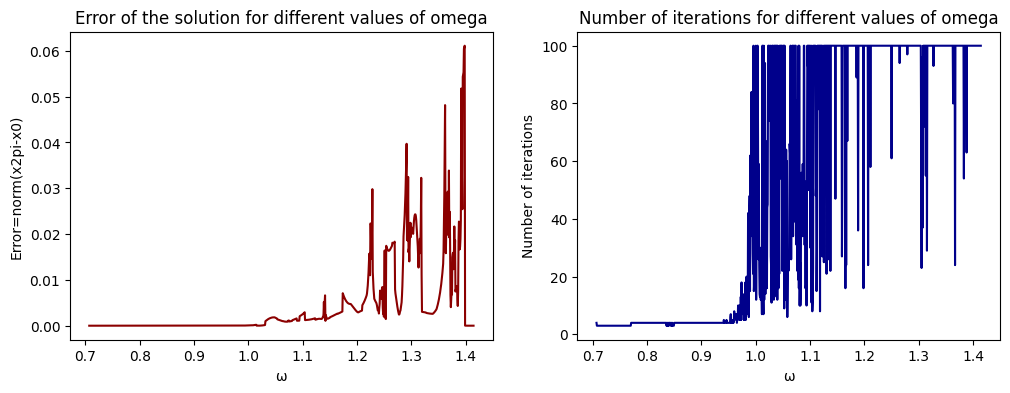

In [115]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Error of the solution for different values of omega")
plt.xlabel("ω")
plt.ylabel("Error=norm(x2pi-x0)")
plt.plot(omega_n, error, color='darkred')

plt.subplot(1, 2, 2)
plt.title("Number of iterations for different values of omega")
plt.xlabel("ω")
plt.ylabel("Number of iterations")
plt.plot(omega_n, n_iter, color='darkblue')

As we can observe, around the value $\omega=1$ the Newton method presents problems, as it was anticipated. The method begins to not converge, in general it takes a much larger number of iterations to converge and the error is larger. The error is large enough to deem the obtained solution as not an actual zero of the map. Clearly, for the nature of this method, once the Newton method does not converge once, the next iterates o the method are basically random guesses for the initial seed of the Newton method and thus also for the computed zero of the method.
For this reason, we can expect similar results applying the method descending from the value of $\omega=\sqrt{2}$, even if not given for sure. We thus different continuation method in the following part.

Changing the approach, we will now deal with $\omega$ as a variable, instead of a parameter, and increase the dimension of the problem we are considering. We can define a function $G: \mathbb{R}^3 \rightarrow \mathbb{R}^2$ as 

$$G(x,y,\omega) = (y, -\omega^2sinx+\epsilon sint)$$

Defining $G$ as above implies that a fixed point for the function $G$ is also a fixed point for our original problem. We now use the technique of looking for the intersection with a circumference of radius $\delta$, meaning we want to solve 

$$\begin{cases} G(z)-z=0 \\ ||z-z_0||^2-\delta^2=0\end{cases}$$

Defining $H(z) = ||z-z_0||^2 - \delta^2 = 0$ and $F(z) = (G(z)-z, H(z))$, we are interested in finding a zero of the function $F$. This will give us a point that belongs to the circumference of radius $\delta$, meaning that we can adjust $\delta$ to move on the implicitly defined function, and a zero for the function $G(z)-z$, meaning a fixed point for our initially considered map, $\mathcal{P}_{\omega=\omega[n]}$. We will find this point by using the Newton method, and in order to do so we will need the differentials with respect to the previous point, similarly to what we were doing before with the variationals. However, we now need to consider a differnt ODE system, taking into account $\omega$ as a variable. We thus have to solve the following

$$\begin{cases} \dot{x} = y \\
    \dot{y} = -\omega^2sinx + \epsilon sint \\
    \dot{w} = 0 \\
    \dot{v_{11}} = v_{21} \\
    \dot{v_{12}} = v_{22} \\
    \dot{v_{13}} = v_{23} \\
    \dot{v_{21}} = -\omega^2cosx v_{11} - 2\omega sinx v_{31} \\
    \dot{v_{22}} = -\omega^2cosx v_{12} - 2\omega sinx v_{32} \\
    \dot{v_{23}} = -\omega^2cosx v_{13} - 2\omega sinx v_{33} \\
    \dot{v_{31}} = 0 \\ 
    \dot{v_{32}} = 0 \\
    \dot{v_{33}} = 0 \end{cases}$$

Let's start by defining this new Cauchy problem we will need to solve using the numerical integration method we also adopted before

In [116]:
# In this section we redefine the previously used function for handling better some aspects. Their base fucntion remains the same 
def Cauchy_problem_2(t, initial_conditions, epsilon=1e-2):
    x, y, w, v11, v12, v13, v21, v22, v23, v31, v32, v33 = initial_conditions
    dx = y
    dy = -(w**2)*np.sin(x) + epsilon*np.sin(t)
    dw = 0
    dv11 = v21
    dv12 = v22
    dv13 = v23
    dv21 = -(w**2)*np.cos(x)*v11 - 2*w*np.sin(x)*v31
    dv22 = -(w**2)*np.cos(x)*v12 - 2*w*np.sin(x)*v32
    dv23 = -(w**2)*np.cos(x)*v13 - 2*w*np.sin(x)*v33
    dv31 = 0
    dv32 = 0
    dv33 = 0
    return [dx, dy, dw, dv11, dv12, dv13, dv21, dv22, dv23, dv31, dv32, dv33]

def Variationals(t_span, initial_conditions, args=(omega, epsilon), Problem=1):
    ''' Returns x, y, and the Variationals with respect to the initial conditions at time 2pi
    '''
    if Problem==1:
        sol = solve_ivp(Cauchy_problem_1, t_span, initial_conditions, method='RK45', args=args)
        xy_final = sol.y[:2,-1]
        dv11, dv12, dv21, dv22 = sol.y[2:,-1]
        return xy_final, np.array([[dv11, dv12], [dv21, dv22]])
    if Problem==2:
        sol = solve_ivp(Cauchy_problem_2, t_span, initial_conditions, method='RK45')
        xyw_final = sol.y[:3,-1]
        dv11, dv12, dv13, dv21, dv22, dv23, dv31, dv32, dv33 = sol.y[3:,-1]
        return xyw_final, np.array([[dv11, dv12, dv13], [dv21, dv22, dv23], [dv31, dv32, dv33]])


Now, to implement the Newton method that we will use to compute a zero of the previously defined function $F$, we need the Jacobian, meaning we need the differentials with respect to the intial point. (the current point we are considering in our continuation method) The first components of the Jacobian matrix will be the components obtained from the variationals, while the derivatives of $H$ are pretty simple to compute simbolically. The obtained Jacobian matrix will be

$$J_F = \begin{bmatrix}  v_{11}-1 & v_{12} & v_{13} \\ 
v_{21} & v_{22}-1 & v_{23} \\
2(x-x_0) & 2(y-y_0) & 2(\omega-\omega_0) \end{bmatrix}$$

And for the initial seed to use for the Newton method we will use, as seen in class, the initial guess 

$$z_0 + \delta v_0, \;\;\; \text{with } v_0=\frac{\overrightarrow{z_0z_{-1}}}{||\overrightarrow{z_0z_{-1}}||}$$

where $z_0$ is the current zero, meaning the current center of the circumference, and $z_{-1}$ is the previous zero. Clearly, this gives problem in defining $v_0$ on the first iteration of our continuation method. This is solved by doing the first iteration using the naive basic method we used before, meaning a simple application of the Newton method to a map making use of a slightly larger value of $\omega$ and the fixed point of the  map with the initial value of $\omega$ as the seed for the method. 
Let us start by defining the Newton method with all the details and particulars we just discussed

In [117]:
def Newton_method_dim3(Z0, center, t_span=[0,2*np.pi], max_iter=100, tol=1e-15, output=True):
    # args=(epsilon,)   # epsilon is now the only parameter, so we never have to change the parameters and thus can avoid passing them to the function
    Z1 = Z0
    for i in range(max_iter):
        initial_conditions = [Z1[0], Z1[1], Z1[2], 1, 0, 0, 0, 1, 0, 0, 0, 0]
        xyw_final, V = Variationals(t_span, initial_conditions, Problem=2)
        J = np.array([[V[0,0]-1, V[0,1], V[0,2]], [V[1,0], V[1,1]-1, V[1,2]], [2*(Z1[0]-center[0]), 2*(Z1[1]-center[1]), 2*(Z1[2]-center[2])]])
        Z2 = Z1 - np.dot(np.linalg.inv(J), (xyw_final-Z1))       # Here computing the inverse using this function is not computationally optimal, but for the objective of the exercise it should be fine
        if np.linalg.norm(Z2-Z1) < tol:                                                    # and in this case it could be done by hand. But, since it is not exactly the object
            if output==True:
                print("The method converged to the solution: (", Z2[0], ",", Z2[1], ")")   #  of this exercise, we can use it, as it is conceptually equivalent
                print("The method converged in", i, "iterations")
            return Z2, i
        Z1 = Z2 
    
    if output==True:
        print("The fixed point Newton method did not converge to a solution.")
        
    return Z2, max_iter

Now in order to define the continuation method we will implement also a stepsize control over the value of $\delta$, allowing it to grow larger when moving on a curve with small curvature, and smaller when moving on a curve with larger curvature. To make sure the step does not grow extremely large we also limit from above with a value of, for example, $10^{-3}$. Notice that we define a function that stores also all the values of the zeros it finds for the different values of $\omega$; for the method to work correctly it would be sufficient to store the value of the previous zero, but we do so in order to be able to also visualize the results. Purely for the same reason we also store the behavior of some other values, such as the error and the number of iterates of the Newton method for different values of $\omega$. 

In [158]:
def continuation_method(X0, delta_increase=1.02, max_iter=1000, t_span=[0,2*np.pi], omega_1=1/np.sqrt(2), omega_2=np.sqrt(2), epsilon=1e-2, tol=1e-15):   
    # Storing vectors
    Z_n = []
    error = []
    n_iter = []

    # Newton method to find the zero for the first value of omega
    X_periodic, iter = Newton_method(X0, omega=omega_1, output=False)
    # Evaluation
    x2pi = solve_ivp(pendulum, t_span, X_periodic, method='RK45', args=(omega_1, epsilon)).y[:,-1]
    Z_n.append(np.concatenate((X_periodic, np.array([omega_1]))))
    error.append(np.linalg.norm(X_periodic-x2pi))
    n_iter.append(iter)

    # First iteration of the method using the first approach
    omega_incr = omega_1+np.sign(omega_2-omega_1)*1e-5
    X_periodic, iter = Newton_method(X_periodic, omega=omega_incr, output=False)
    # Evaluation
    x2pi = solve_ivp(pendulum, t_span, X_periodic, method='RK45', args=(omega_incr, epsilon)).y[:,-1]
    Z_n.append(np.concatenate((X_periodic, np.array([omega_incr]))))
    error.append(np.linalg.norm(X_periodic-x2pi))
    n_iter.append(iter)

    delta = 1e-5
    v_0 = (Z_n[-1]-Z_n[-2])/(np.linalg.norm(Z_n[-1]-Z_n[-2]))
    Z1 = Z_n[-1]+delta*v_0   # This is the initial seed
    i = 0

    while (np.sign(omega_2-omega_1)*(Z_n[-1])[2]<np.sign(omega_2-omega_1)*omega_2 and i<=max_iter):
        # Continuation method iteration
        Z_periodic, iter = Newton_method_dim3(Z1, center=Z_n[-1], output=False)
        # Evaluation 
        x2pi = solve_ivp(pendulum, t_span, Z_periodic[:2], method='RK45', args=(Z_periodic[2], epsilon)).y[:,-1]
        Z_n.append(Z_periodic)
        error.append(np.linalg.norm(Z_periodic[:2]-x2pi))
        n_iter.append(iter)

        # Updates for the next step
        if (iter<10 and delta<1e-3):
            delta = delta*delta_increase
        if iter>10:
            delta = delta/delta_increase

        if np.dot((Z_n[-1]-Z_n[-2])/(np.linalg.norm(Z_n[-1]-Z_n[-2])), v_0)>=0:
            v_0 = (Z_n[-1]-Z_n[-2])/(np.linalg.norm(Z_n[-1]-Z_n[-2]))
        else:
            v_0 = -(Z_n[-1]-Z_n[-2])/(np.linalg.norm(Z_n[-1]-Z_n[-2]))
        Z1 = Z_n[-1]+delta*v_0   # This is the initial seed
        i = i+1

    return Z_n, error, n_iter

All considered this continuation method is the implementation of the one we discussed in class. However, as it is clear from the following cells, the method still has troubles around the value of $\omega=1$

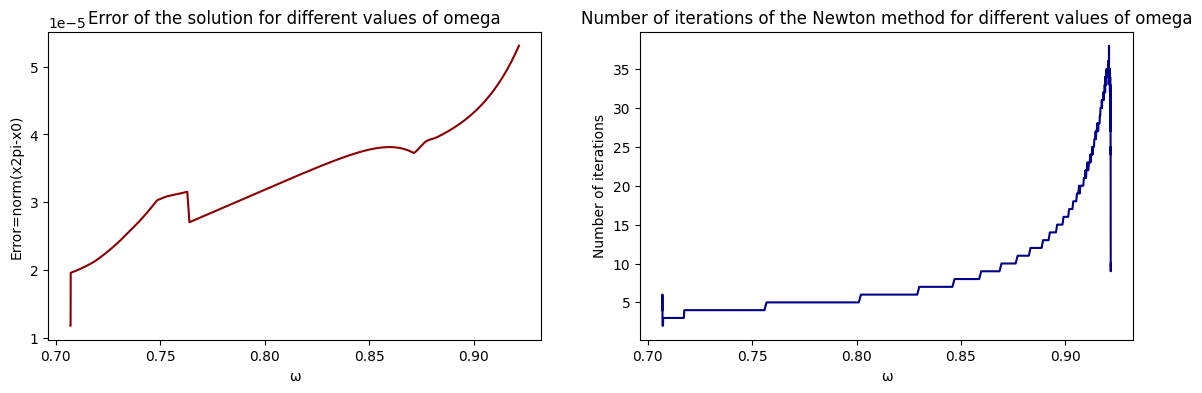

In [159]:
X0 = [0, 0]   # Initial guess
Z_n_left, error_left, n_iter_left = continuation_method(X0)

omega_n_left = []
for Z in Z_n_left:
    omega_n_left.append(Z[-1])

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title("Error of the solution for different values of omega")
plt.xlabel("ω")
plt.ylabel("Error=norm(x2pi-x0)")
plt.plot(omega_n_left, error_left, color='darkred')

plt.subplot(1, 2, 2)
plt.title("Number of iterations of the Newton method for different values of omega")
plt.xlabel("ω")
plt.ylabel("Number of iterations")
plt.plot(omega_n_left, n_iter_left, color='darkblue')

* **Starting at $\omega=\sqrt{2}$ down to $\omega=\frac{1}{\sqrt{2}}$**

Now in order to run the continuation method starting from $\omega=\sqrt{2}$ down to $\omega=\frac{1}{\sqrt{2}}$ we can simply use the same function using $\sqrt{2}$ as the first value of $\omega$ and $\frac{1}{\sqrt{2}}$ as the last value of $\omega$. This because the continuation method function has been written to invert the sign of all the operations where it is necessary based on if the method is ascending or descending from the first value of $\omega$

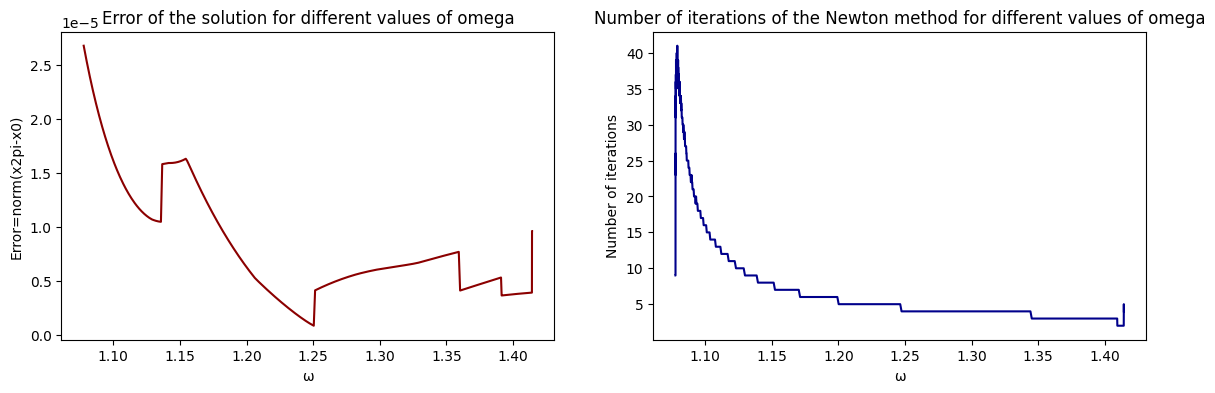

In [160]:
X0 = [0, 0]   # Initial guess
Z_n_right, error_right, n_iter_right = continuation_method(X0, omega_1=np.sqrt(2), omega_2=1/np.sqrt(2))

omega_n_right = []
for Z in Z_n_right:
    omega_n_right.append(Z[-1])

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title("Error of the solution for different values of omega")
plt.xlabel("ω")
plt.ylabel("Error=norm(x2pi-x0)")
plt.plot(omega_n_right, error_right, color='darkred')

plt.subplot(1, 2, 2)
plt.title("Number of iterations of the Newton method for different values of omega")
plt.xlabel("ω")
plt.ylabel("Number of iterations")
plt.plot(omega_n_right, n_iter_right, color='darkblue')

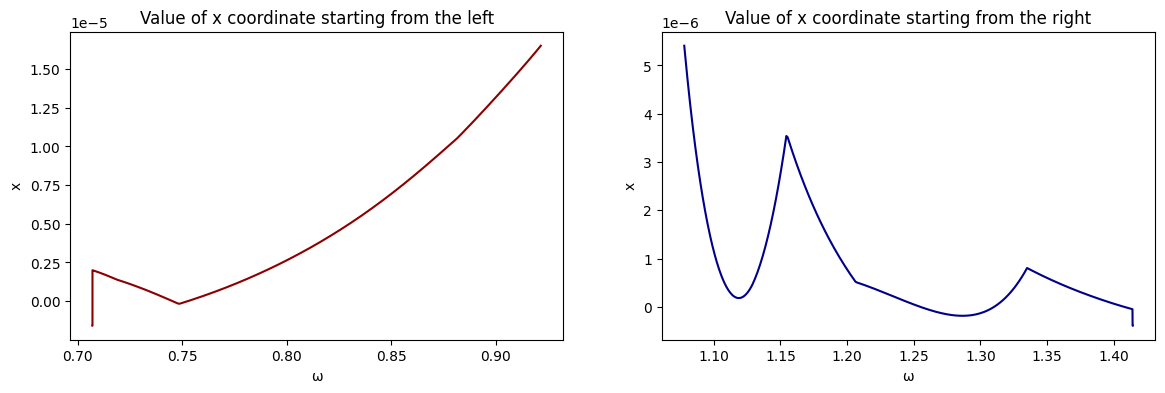

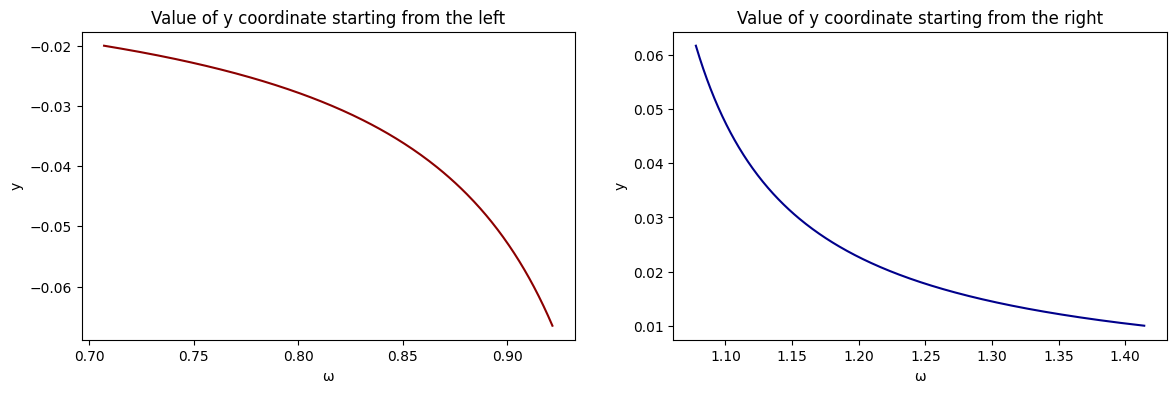

In [161]:
x_left = []
y_left = []
x_right = []
y_right = []

for Z in Z_n_left:
    x_left.append(Z[0])
    y_left.append(Z[1])
for Z in Z_n_right:
    x_right.append(Z[0])
    y_right.append(Z[1])

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title("Value of x coordinate starting from the left")
plt.xlabel("ω")
plt.ylabel("x")
plt.plot(omega_n_left, x_left, color='darkred')

plt.subplot(1, 2, 2)
plt.title("Value of x coordinate starting from the right")
plt.xlabel("ω")
plt.ylabel("x")
plt.plot(omega_n_right, x_right, color='darkblue')

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title("Value of y coordinate starting from the left")
plt.xlabel("ω")
plt.ylabel("y")
plt.plot(omega_n_left, y_left, color='darkred')

plt.subplot(1, 2, 2)
plt.title("Value of y coordinate starting from the right")
plt.xlabel("ω")
plt.ylabel("y")
plt.plot(omega_n_right, y_right, color='darkblue')

Observing these plots, we can understand why the method presents problems around the value of $\omega=1$. As we can see there is a discontinuity around $\omega=1$, with the value of $y$ in particular having a large difference in their values. For this reason the continuation method is not able to go over the value of $\omega=1$ because the initial guesses of the newton method are not close to the next point and thus the value of $\delta$ keeps getting smaller and smaller. 
It should be noticed though that in this case we limited the value of $\delta$ from above and not from below. Using a larger upper limit or also limiting its value from below allows to go over the value of $\delta=1$. However, such a technique would not be reliable and precise and would in fact yeld some strange results, even though it might be in some cases, in particular with small and relatively close values, somewhat effective, in the sense that it would not stop in front small discontinuities at the cost of losing precision and reliability.
Here it follows an example of the behavior of the method using less strict limitations on the value of $\delta$, which would be more of a 'reckless' method. (**Attention: this is not suggesting it should be chosen as an approach**)

In [166]:
def continuation_method(X0, delta_increase=1.02, max_iter=1000, t_span=[0,2*np.pi], omega_1=1/np.sqrt(2), omega_2=np.sqrt(2), epsilon=1e-2, tol=1e-15):   
    # Storing vectors
    Z_n = []
    error = []
    n_iter = []

    # Newton method to find the zero for the first value of omega
    X_periodic, iter = Newton_method(X0, omega=omega_1, output=False)
    # Evaluation
    x2pi = solve_ivp(pendulum, t_span, X_periodic, method='RK45', args=(omega_1, epsilon)).y[:,-1]
    Z_n.append(np.concatenate((X_periodic, np.array([omega_1]))))
    error.append(np.linalg.norm(X_periodic-x2pi))
    n_iter.append(iter)

    # First iteration of the method using the first approach
    omega_incr = omega_1+np.sign(omega_2-omega_1)*1e-5
    X_periodic, iter = Newton_method(X_periodic, omega=omega_incr, output=False)
    # Evaluation
    x2pi = solve_ivp(pendulum, t_span, X_periodic, method='RK45', args=(omega_incr, epsilon)).y[:,-1]
    Z_n.append(np.concatenate((X_periodic, np.array([omega_incr]))))
    error.append(np.linalg.norm(X_periodic-x2pi))
    n_iter.append(iter)

    delta = 1e-3
    v_0 = (Z_n[-1]-Z_n[-2])/(np.linalg.norm(Z_n[-1]-Z_n[-2]))
    Z1 = Z_n[-1]+delta*v_0   # This is the initial seed
    i = 0

    while (np.sign(omega_2-omega_1)*(Z_n[-1])[2]<np.sign(omega_2-omega_1)*omega_2 and i<=max_iter):
        # Continuation method iteration
        Z_periodic, iter = Newton_method_dim3(Z1, center=Z_n[-1], output=False)
        # Evaluation 
        x2pi = solve_ivp(pendulum, t_span, Z_periodic[:2], method='RK45', args=(Z_periodic[2], epsilon)).y[:,-1]
        Z_n.append(Z_periodic)
        error.append(np.linalg.norm(Z_periodic[:2]-x2pi))
        n_iter.append(iter)

        # Updates for the next step
        if (iter<10 and delta<1e-1):
            delta = delta*delta_increase
        if iter>10:
            delta = delta/delta_increase

        if np.dot((Z_n[-1]-Z_n[-2])/(np.linalg.norm(Z_n[-1]-Z_n[-2])), v_0)>=0:
            v_0 = (Z_n[-1]-Z_n[-2])/(np.linalg.norm(Z_n[-1]-Z_n[-2]))
        else:
            v_0 = -(Z_n[-1]-Z_n[-2])/(np.linalg.norm(Z_n[-1]-Z_n[-2]))
        Z1 = Z_n[-1]+delta*v_0   # This is the initial seed
        i = i+1

    return Z_n, error, n_iter

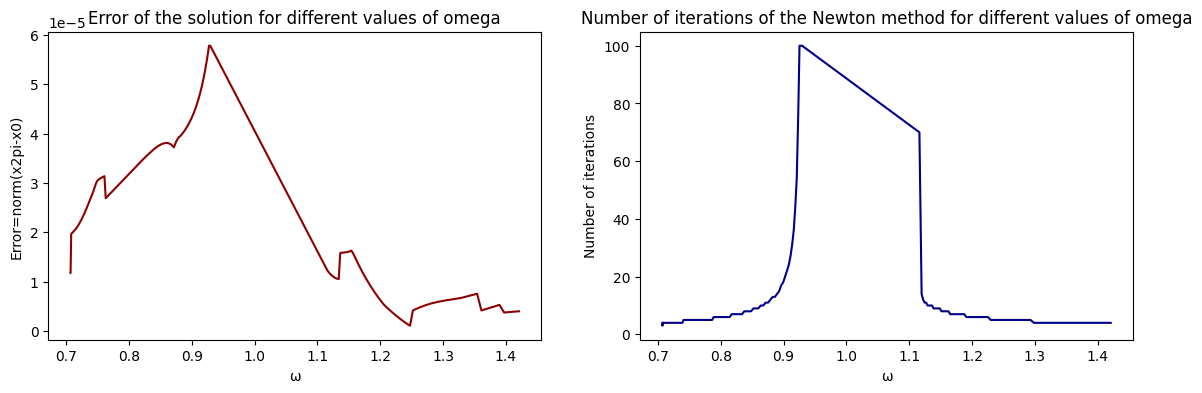

In [167]:
X0 = [0, 0]   # Initial guess
Z_n_left, error_left, n_iter_left = continuation_method(X0)

omega_n_left = []
for Z in Z_n_left:
    omega_n_left.append(Z[-1])

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title("Error of the solution for different values of omega")
plt.xlabel("ω")
plt.ylabel("Error=norm(x2pi-x0)")
plt.plot(omega_n_left, error_left, color='darkred')

plt.subplot(1, 2, 2)
plt.title("Number of iterations of the Newton method for different values of omega")
plt.xlabel("ω")
plt.ylabel("Number of iterations")
plt.plot(omega_n_left, n_iter_left, color='darkblue')

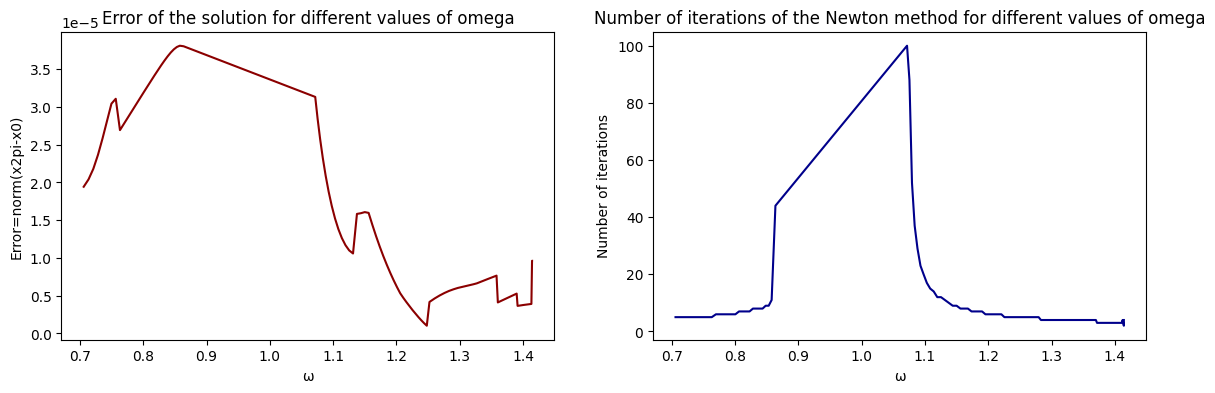

In [168]:
X0 = [0, 0]   # Initial guess
Z_n_right, error_right, n_iter_right = continuation_method(X0, omega_1=np.sqrt(2), omega_2=1/np.sqrt(2))

omega_n_right = []
for Z in Z_n_right:
    omega_n_right.append(Z[-1])

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title("Error of the solution for different values of omega")
plt.xlabel("ω")
plt.ylabel("Error=norm(x2pi-x0)")
plt.plot(omega_n_right, error_right, color='darkred')

plt.subplot(1, 2, 2)
plt.title("Number of iterations of the Newton method for different values of omega")
plt.xlabel("ω")
plt.ylabel("Number of iterations")
plt.plot(omega_n_right, n_iter_right, color='darkblue')

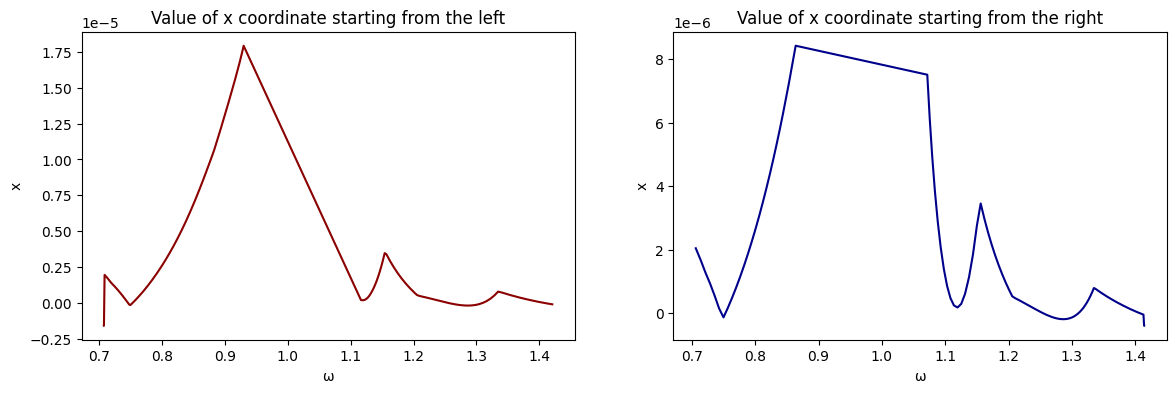

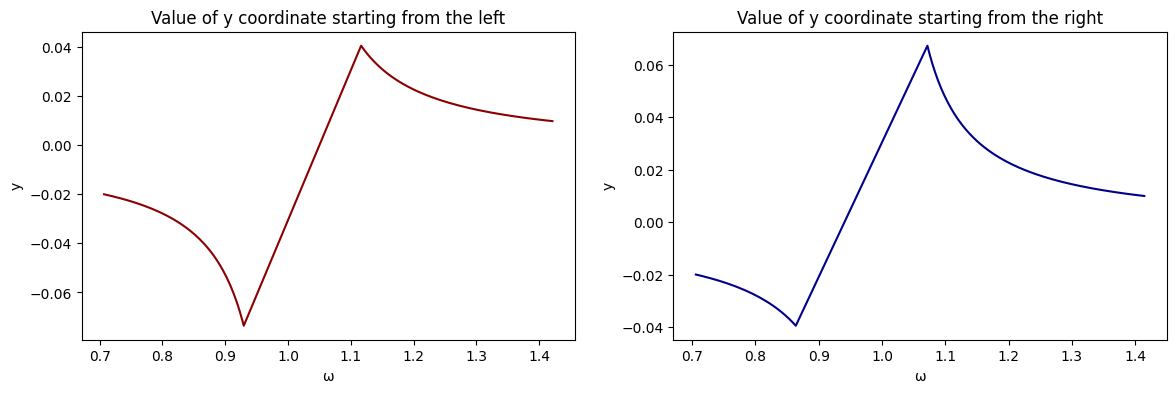

In [169]:
x_left = []
y_left = []
x_right = []
y_right = []

for Z in Z_n_left:
    x_left.append(Z[0])
    y_left.append(Z[1])
for Z in Z_n_right:
    x_right.append(Z[0])
    y_right.append(Z[1])

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title("Value of x coordinate starting from the left")
plt.xlabel("ω")
plt.ylabel("x")
plt.plot(omega_n_left, x_left, color='darkred')

plt.subplot(1, 2, 2)
plt.title("Value of x coordinate starting from the right")
plt.xlabel("ω")
plt.ylabel("x")
plt.plot(omega_n_right, x_right, color='darkblue')

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title("Value of y coordinate starting from the left")
plt.xlabel("ω")
plt.ylabel("y")
plt.plot(omega_n_left, y_left, color='darkred')

plt.subplot(1, 2, 2)
plt.title("Value of y coordinate starting from the right")
plt.xlabel("ω")
plt.ylabel("y")
plt.plot(omega_n_right, y_right, color='darkblue')

These results are obtained by simply using as a upper limit for $\delta$, $10^{-1}$ instead of $10^{-3}$. Which shows how this method still needs case-specific attention and tuning of the parameters. Fortunately, we can also notice how from the values of the error the number of iterates necessary to the Newton method and the behaviour and smoothness of the values of the coordinates we can easily notice if the solutions produced by the method are not being reliable.